# SwarmPRM  + Time

In [1]:
%matplotlib inline

## Road Map tests


#### Import and setup

In [2]:
from swarm_prm.envs.roadmap import RoadmapLoader
from swarm_prm.envs.instance import InstanceLoader
from swarm_prm.solvers.swarm_prm.macro.gaussian_prm import GaussianPRM


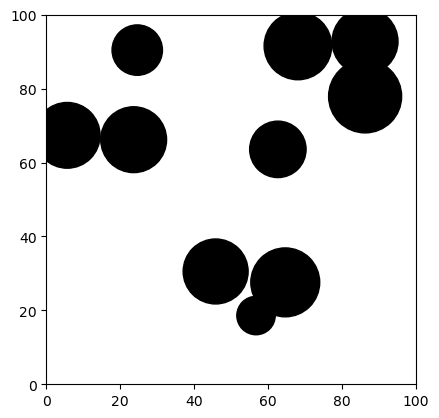

In [9]:
map_fname = "data/envs/maps/map_2.yaml"
map_loader = RoadmapLoader(map_fname)
# instance_loader = InstanceLoader(instance_fname)
roadmap, _ = map_loader.get_map()
roadmap.visualize()
# instance_fname = "data/envs/maps/map_2.yaml"
# instance = instance_loader.get_instance() 
gaussian_prm = GaussianPRM(roadmap, None, 500)
# gaussian_prm.load_instance()
gaussian_prm.sample_free_space(sampling_strategy="UNIFORM")
gaussian_prm.build_roadmap(roadmap_method="TRIANGULATION", kd_radius=30, collision_check_method="CVAR")

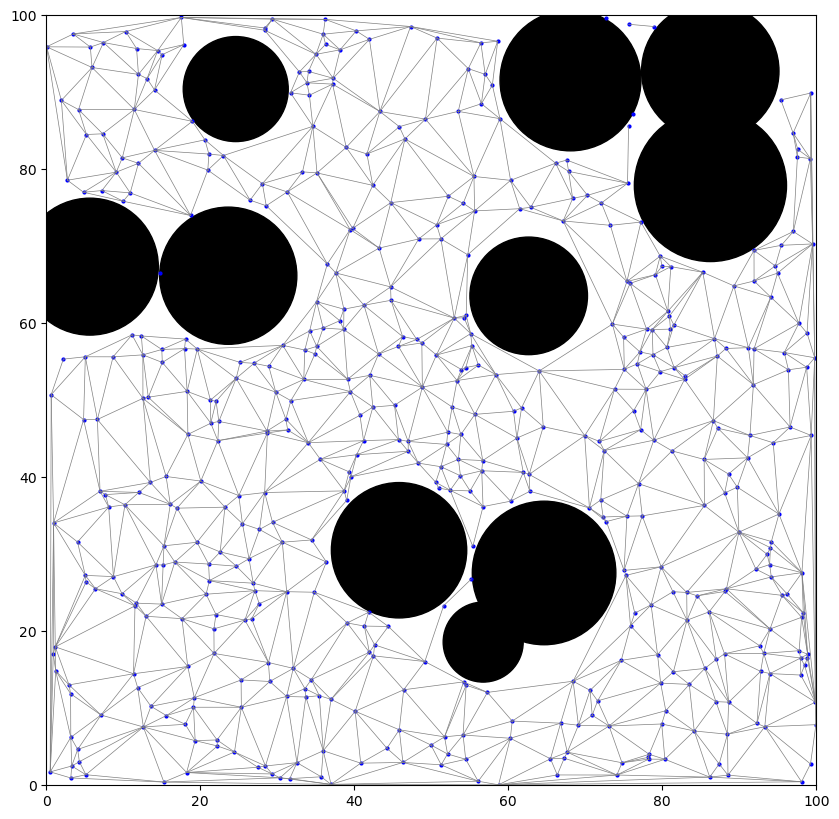

In [10]:
gaussian_prm.visualize_roadmap("test_map")

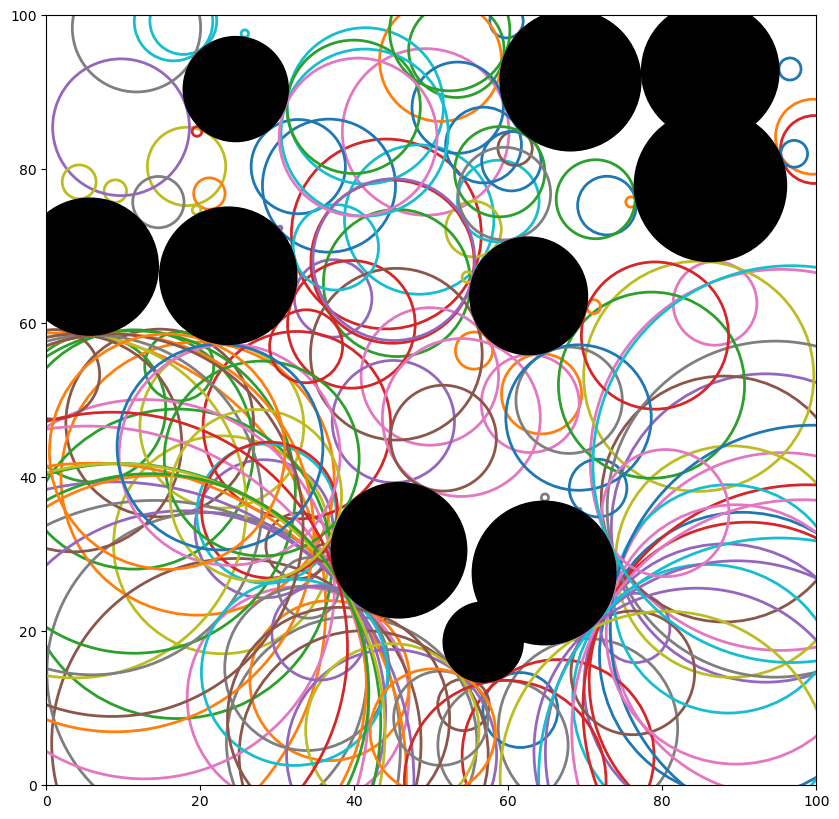

In [5]:
gaussian_prm.visualize_g_nodes("test_g_nodes")

#### CVAR test

In [6]:

from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np
from scipy.stats import norm, chi2

from swarm_prm.solvers.swarm_prm.macro.gaussian_prm import GaussianNode
from swarm_prm.envs.roadmap import Roadmap, CircleObstacle


def obstacle_gaussian_collision(obs: CircleObstacle, g_node: GaussianNode, alpha, thresh, ax) -> bool:
    """
        Using CVaR and threshold to test if node is too close to obstacle.
        Return True if CVaR is greater than the threshold.
        Reference: SwarmPRM
    """

    # Plot normal vector
    mean = -obs.get_dist(g_node.get_mean())
    v_normal = (obs.pos - g_node.get_mean()) / (np.linalg.norm(obs.pos - g_node.get_mean()))
    start_pos = g_node.get_mean()
    end_pos = start_pos - v_normal * mean
    vec = np.vstack([start_pos, end_pos]).T
    ax.plot(vec[0], vec[1])

    variance = v_normal.T @ g_node.covariance @ v_normal
    ita = norm(mean, variance)
    cvar = mean + ita.pdf(ita.ppf(1-alpha))/alpha * variance
    print(cvar)
    return cvar > thresh

def visualize_g_node(g_node, ax, thresh, is_collision):
    # Visualize G nodes
    mean, cov = g_node.get_gaussian()
    # Compute the eigenvalues and eigenvectors of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eigh(cov)

    # Sort eigenvalues and eigenvectors by descending eigenvalue
    order = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[order]
    eigenvectors = eigenvectors[:, order]

    # The angle of the ellipse (in degrees)
    angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))

    # The width and height of the ellipse (2*sqrt(chi2_value*eigenvalue))
    chi2_value = chi2.ppf(thresh, 2)  # threshold confidence interval for 2 degrees of freedom (chi-squared value)
    width, height = 2 * np.sqrt(chi2_value * eigenvalues)
    if is_collision:
        ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle, 
                          edgecolor="red", fc='None', lw=2)
    else:
        ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle, 
                          edgecolor="blue", fc='None', lw=2)
    ax.add_patch(ellipse)


-24.698775198932438
-22.604293854531015
-20.694713459646483
-19.006438350290363
-17.57997962057907
-16.457545240610287
-15.678865087381938
-15.275593738587395
-15.2656365917873
-15.649449775546115
-16.409941200305624
-17.516019053035354
-18.9282176059941
-20.604338982051416
-22.503715274722545
-24.589703042385104
-26.830701535887357
-29.200208141113386
-31.676366566782733
-34.241316541118024


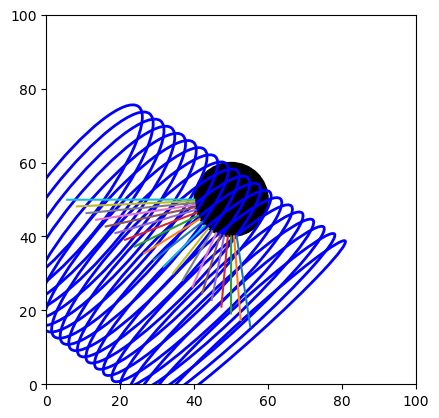

In [7]:

roadmap = Roadmap(100, 100)
pos = np.array([50, 50])
obs = CircleObstacle(pos, 10)
thresh = -8
tolerance = 0.95
alpha = 0.95 
num_g_node = 20 

roadmap.add_obstacle(obs)
fig, ax = roadmap.visualize()
start_mean = np.random.rand(2) * 100
goal_mean = np.random.rand(2) * 100

temp = np.random.rand(2, 2) * 10
start_cov =  temp @ temp.T
temp = np.random.rand(2, 2) * 10
goal_cov =  temp @ temp.T

for i in range(num_g_node):
    mean = i / (num_g_node) * start_mean + (num_g_node - i) / num_g_node * goal_mean
    cov = i / (num_g_node) * start_cov + (num_g_node - i) / num_g_node * goal_cov

    g_node = GaussianNode(mean, cov)
    is_collision = obstacle_gaussian_collision(obs,  g_node, alpha, thresh, ax)
    visualize_g_node(g_node, ax, tolerance, is_collision)